In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from late.blackboxes.loader import cached_blackbox_loader
from late.datasets.datasets import load_ucr_dataset
from late.autoencoders.variational_autoencoder_v2 import load_model
# from late.autoencoders.variational_autoencoder import load_model
from late.utils import get_project_root, choose_z
from late.surrogates.shapelet_tree import ShapeletTree
from late.surrogates.sax_tree import SaxTree
from late.neighgen.counter_generator import CounterGenerator
from late.wrappers import DecoderWrapper
from late.deprecated.surrogates.sbgdt import generate_n_shapelets_per_size
from late.explainers.lasts import Lasts

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
random_state = 0
np.random.seed(random_state)
dataset_name = "cbf"

_, _, _, _, _, _, X_exp_train, y_exp_train, X_exp_val, y_exp_val, X_exp_test, y_exp_test = load_ucr_dataset(
    "GunPoint"
)

blackbox = cached_blackbox_loader("GunPoint_rocket.joblib")

encoder, decoder, autoencoder = load_model(get_project_root() / "autoencoders" / "cached" / "vae_v2" /
                                           "GunPoint__ldim4" / "GunPoint__ldim4_vae")

i = 0
x = X_exp_test[i].ravel().reshape(1, -1, 1)
z_fixed = choose_z(x, encoder, decoder, n=1000, x_label=blackbox.predict(x)[0],
                   blackbox=blackbox, check_label=True, mse=False)

neighgen = CounterGenerator(
    blackbox,
    DecoderWrapper(decoder),
    n_search=10000,
    n_batch=1000,
    lower_threshold=0,
    upper_threshold=4,
    kind="gaussian_matched",
    sampling_kind="uniform_sphere",
    vicinity_sampler_kwargs=dict(),
    stopping_ratio=0.01,
    check_upper_threshold=True,
    final_counterfactual_search=True,
    verbose=True,
    custom_sampling_threshold=None,
    custom_closest_counterfactual=None,
    n=500,
    balance=False,
    forced_balance_ratio=0.5,
    redo_search=True,
    cut_radius=True,
)

n_shapelets_per_size = generate_n_shapelets_per_size(X_exp_train.shape[1])
shapelet_model_kwargs = {
    "l": 0.1,
    "r": 2,
    "optimizer": "sgd",
    "n_shapelets_per_size": n_shapelets_per_size,
    "weight_regularizer": .01,
    "max_iter": 100
}

# surrogate = ShapeletTree(random_state=random_state, shapelet_model_kwargs=shapelet_model_kwargs)
surrogate = SaxTree(random_state=random_state)

DATASET INFO:
Label Encoding: [1 2]
X_train:  (50, 150, 1)
y_train:  (50,)

CLASSES BALANCE
0 :  0.48
1 :  0.52

X_test:  (150, 150, 1)
y_test:  (150,)

CLASSES BALANCE
0 :  0.51
1 :  0.49


/Users/francesco/github/late/late/datasets/datasets.py:67: UserWarning: Blackbox and Explanation sets are the same
  warnings.warn("Blackbox and Explanation sets are the same")
2021-12-21 15:25:33.761941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-21 15:25:35.040968: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2021-12-21 15:25:35.429092: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [4]:
lasts_ = Lasts(
    blackbox,
    encoder,
    DecoderWrapper(decoder),
    neighgen,
    surrogate,
    verbose=True,
    binarize_surrogate_labels=True,
    labels=["Gun", "Point"]
)

In [5]:
lasts_.fit(x, z_fixed)

Binary sampling search: gaussian_matched
   Testing threshold value: 2.0
   Testing threshold value: 1.0
   Testing threshold value: 0.5
   Testing threshold value: 0.25
   Testing threshold value: 0.125
   Best threshold found: 0.25
   Final counterfactual search... (this could take a while) Done!
Setting new threshold at radius: 0.6432782672933324

Sampling --> uniform_sphere
Forced balancing neighborhood... Done!


In [6]:
exp = lasts_.explain()
exp.explain()

(((array([[[-1.2434275],
           [-1.239875 ],
           [-1.2945724],
           ...,
           [-1.2093993],
           [-1.2286652],
           [-1.2012044]],
   
          [[-1.297766 ],
           [-1.302153 ],
           [-1.3476549],
           ...,
           [-1.2564445],
           [-1.278678 ],
           [-1.2403165]],
   
          [[-1.2287871],
           [-1.2314317],
           [-1.278633 ],
           ...,
           [-1.1613877],
           [-1.1764612],
           [-1.158888 ]],
   
          ...,
   
          [[-1.1966575],
           [-1.1958773],
           [-1.2299825],
           ...,
           [-1.183885 ],
           [-1.1801463],
           [-1.1527842]],
   
          [[-1.1943283],
           [-1.1833651],
           [-1.2225498],
           ...,
           [-1.1778055],
           [-1.1935962],
           [-1.1706861]],
   
          [[-1.2048317],
           [-1.2021762],
           [-1.2392075],
           ...,
           [-1.1809176],
          

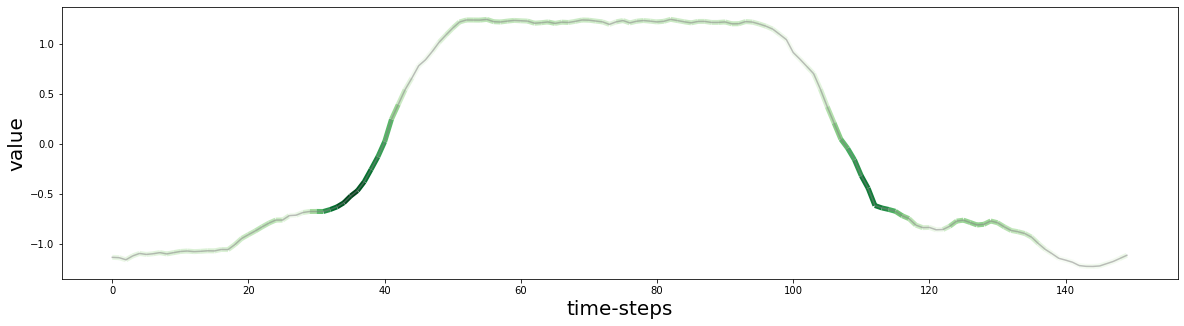

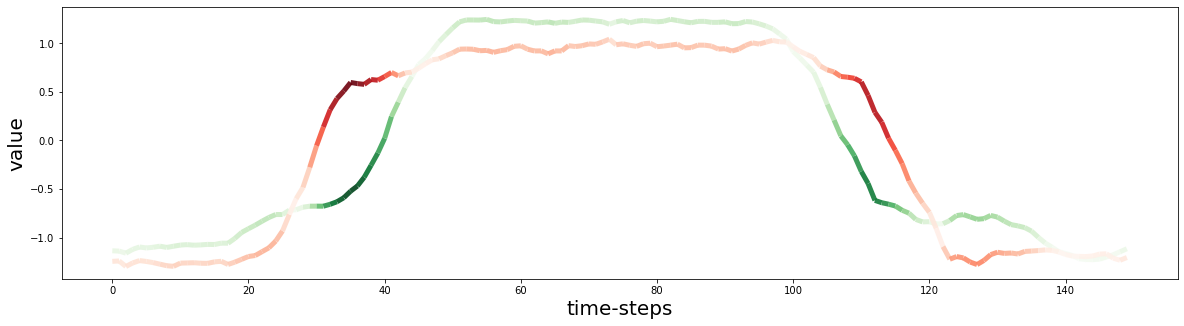

In [7]:
lasts_.plot("saliency_map")
lasts_.plot("counterexemplar_shape_change")

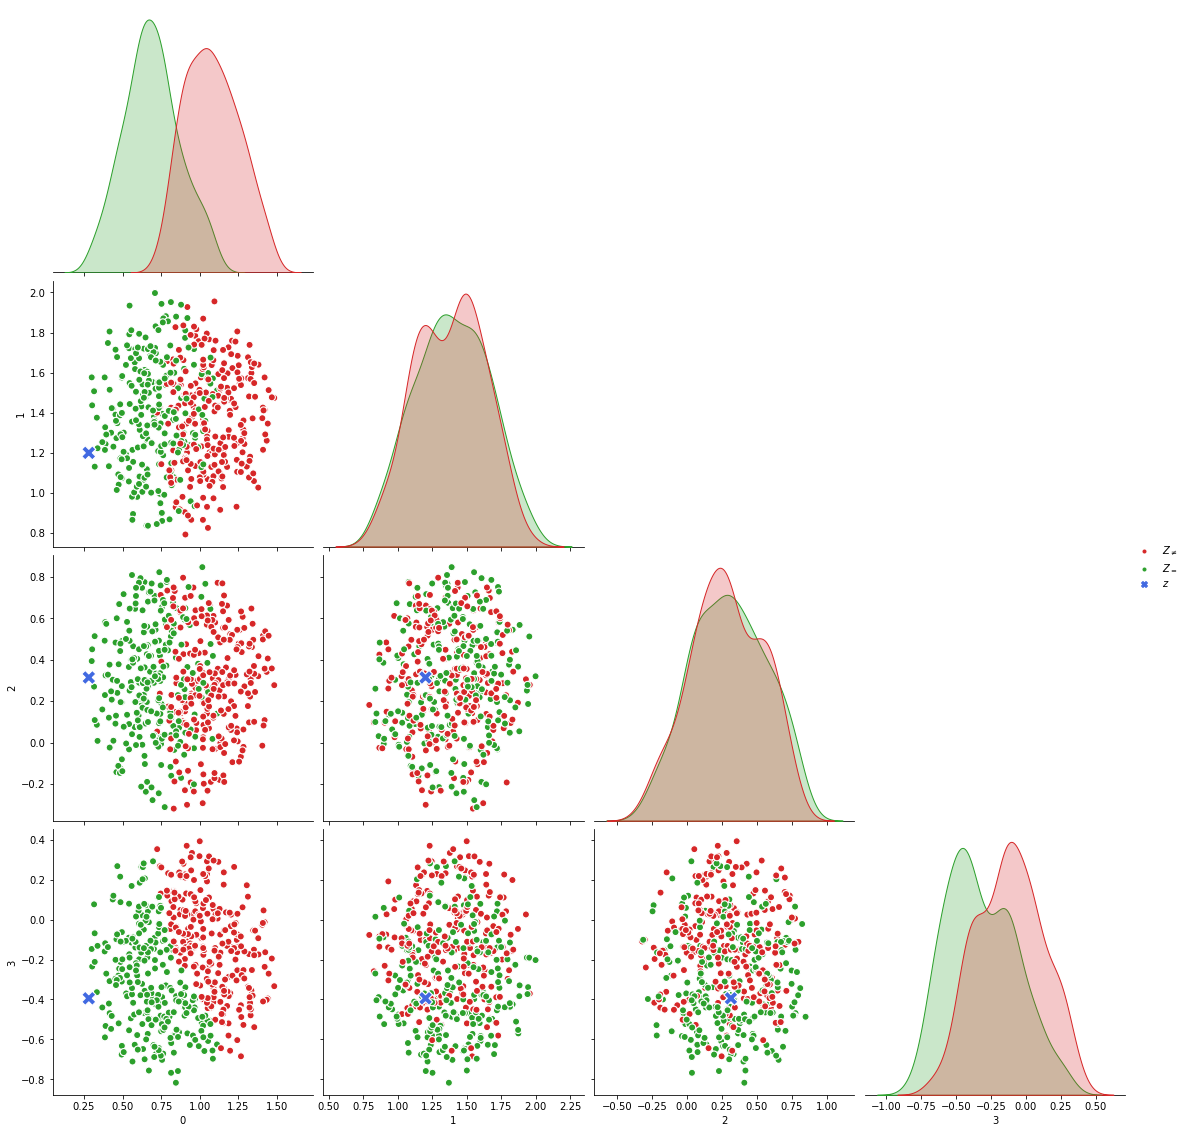

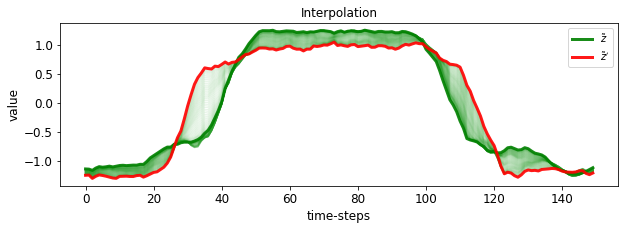

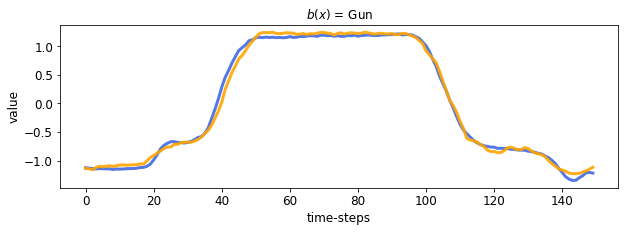

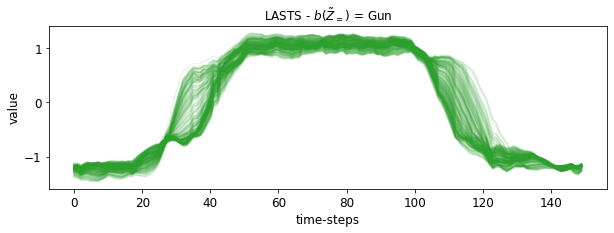

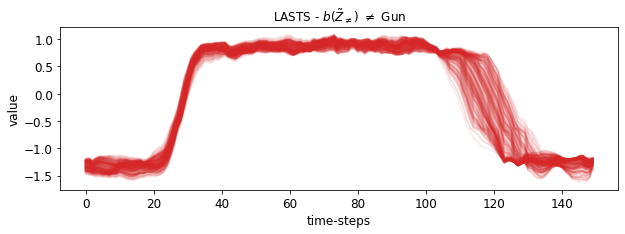

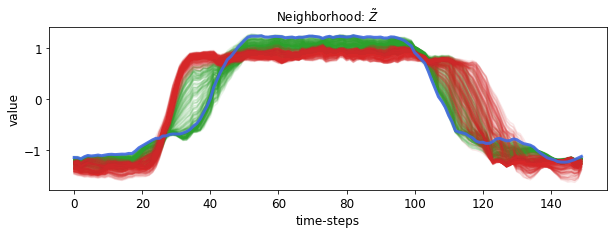

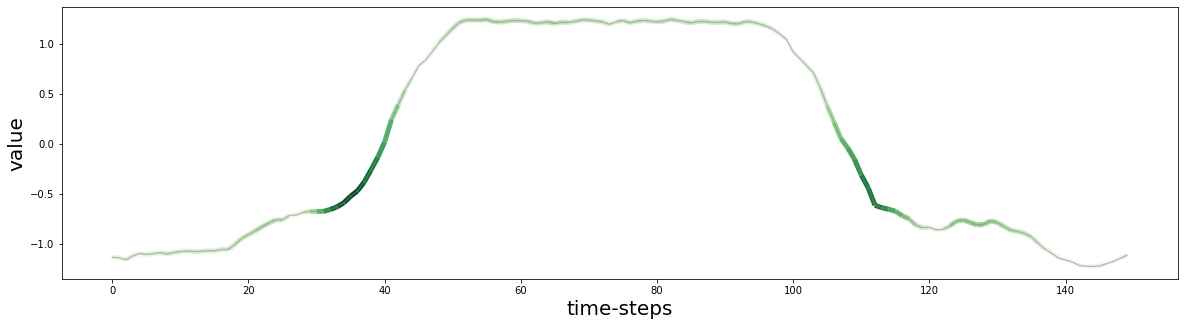

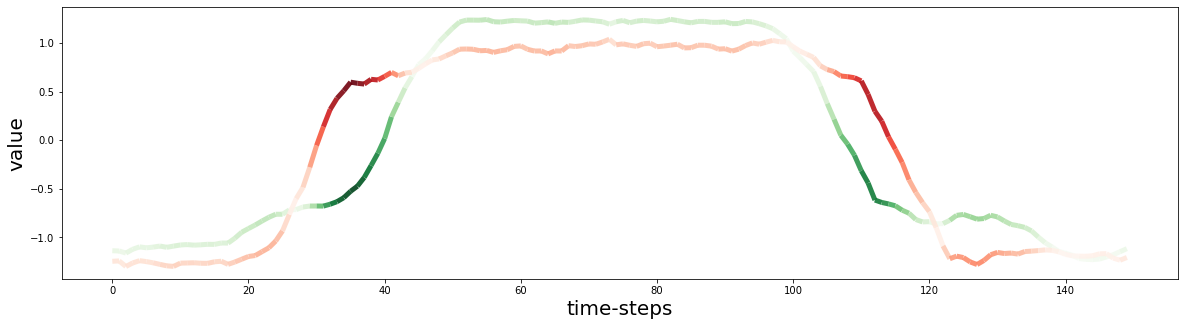

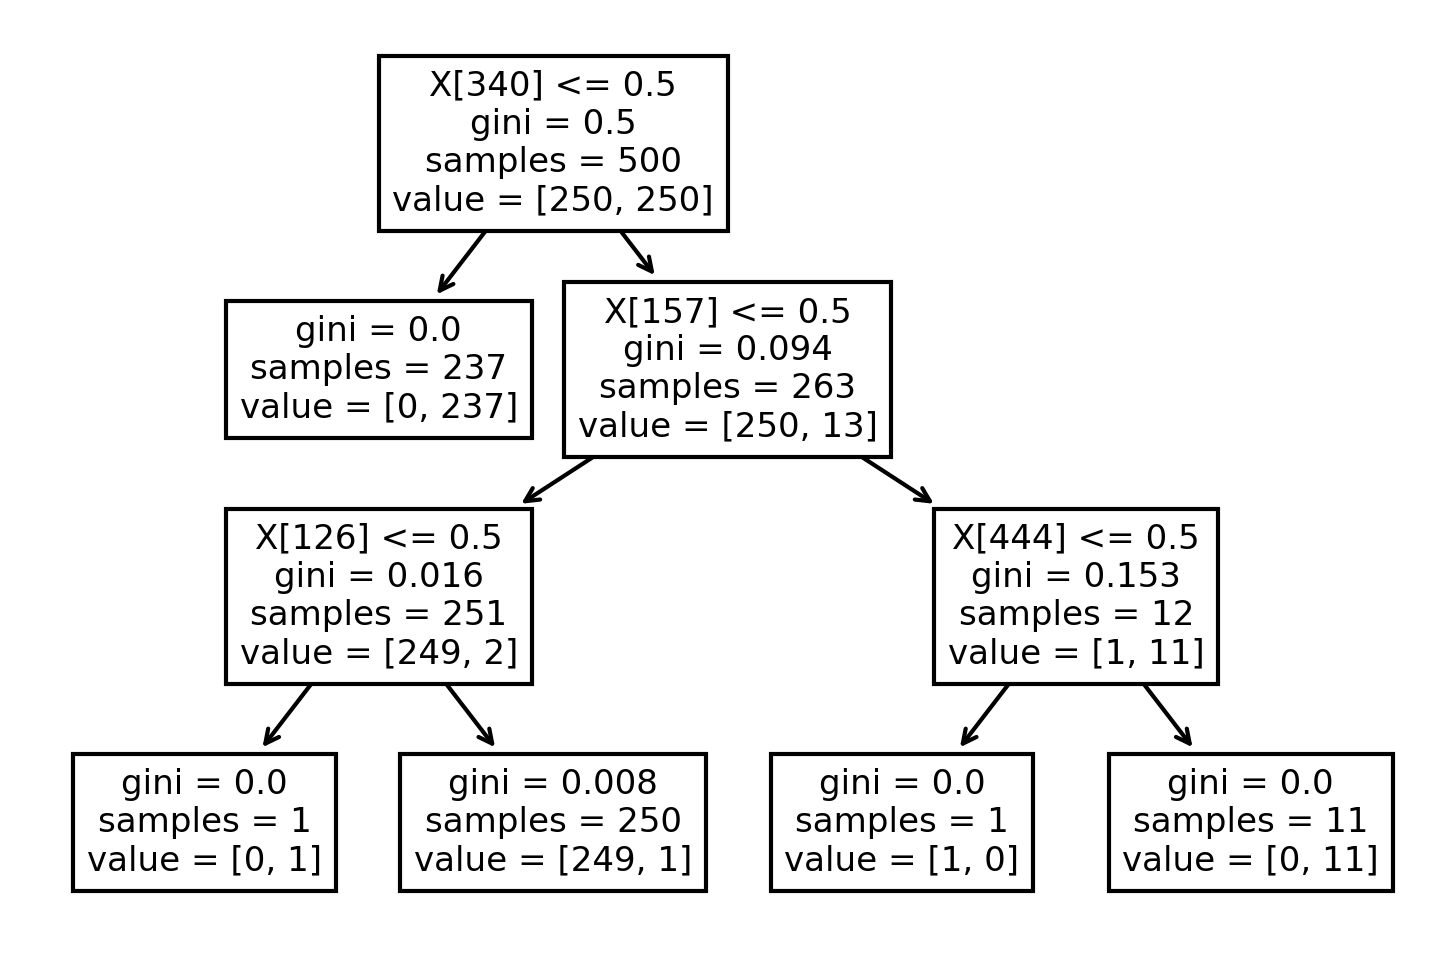

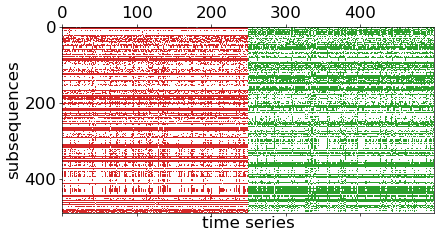

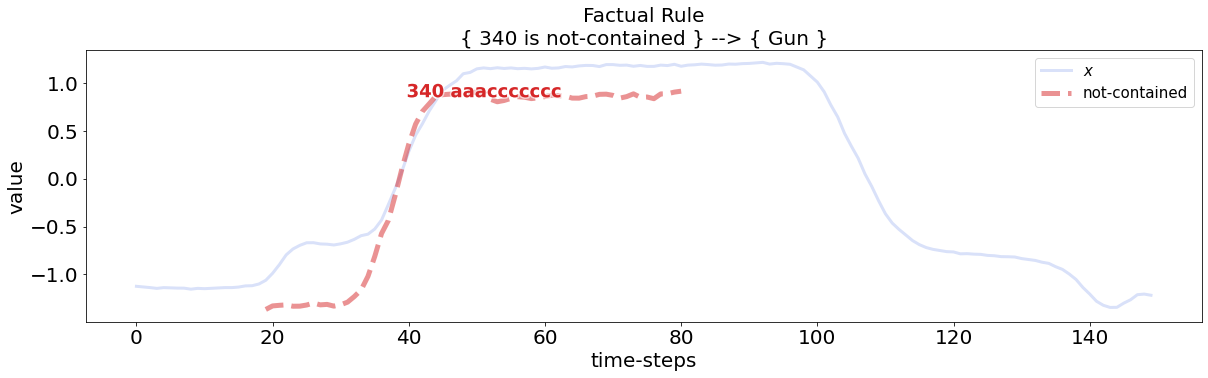

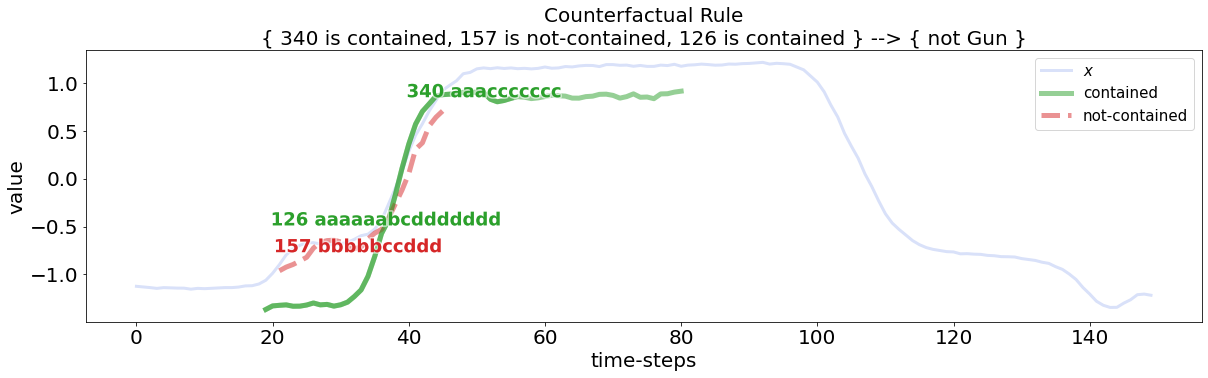

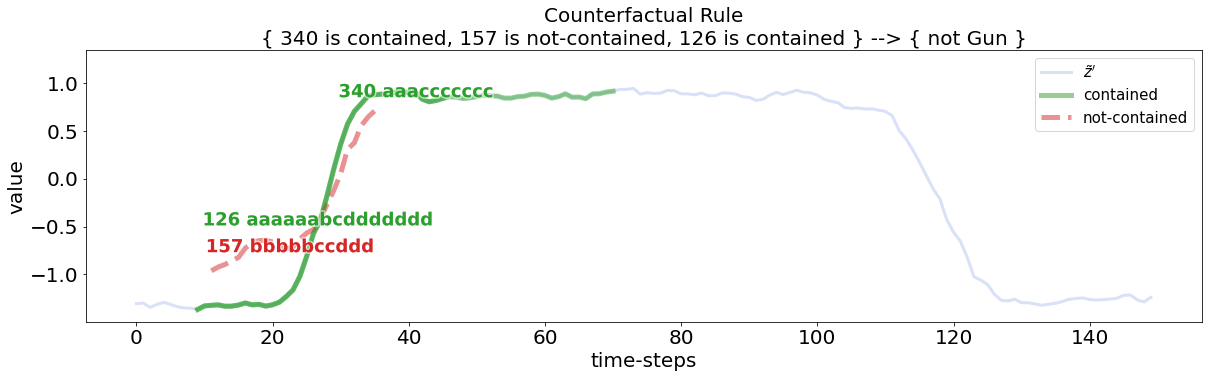

In [13]:
lasts_.plot("latent_space_matrix")
#lasts_.plot("morphing_matrix")
lasts_.plot("counterexemplar_interpolation")
lasts_.plot("manifest_space")
lasts_.plot("saliency_map")
lasts_.plot("counterexemplar_shape_change")
lasts_.plot("tree")
lasts_.plot("subsequences_binary_heatmap")
lasts_.plot("rules")